In [1]:
import json
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt

In [2]:
ticker = 'FB'
url = f"https://api.iextrading.com/1.0/stock/{ticker}/chart/1y"
data1 = json.loads(requests.get(url).content.decode())
df = pd.read_json(url)[['date', 'close']].copy()
df = df.dropna()
df.head()
df = df.set_index("date", drop=False)

In [3]:
# Calculate daily change of FB
change = df['close'].diff()
# Get rid of the first row, which is NaN since it did not have a previous row to calculate the differences
change = change[1:] 

In [4]:
# Make the gains  and loss  Series
gain = change.copy()
gain[gain < 0] = 0
loss = change.copy()
loss[loss>0] = 0
# Calculate the EWMA
avg_gain = gain.ewm(com=11, min_periods=12).mean()
avg_loss = loss.ewm(com=11, min_periods=12).mean()

In [5]:
# Calculate the RSI12 based on EWMA
rs = abs(avg_gain/avg_loss)
rsi12 = 100 - (100/(1+rs))
df['rsi12'] = rsi12

In [6]:
# Calculate the RSI6 based on EWMA
# short term
avg_gain2 = gain.ewm(com=5, min_periods=6).mean()
avg_loss2 = loss.ewm(com=5, min_periods=6).mean()
rs2 = abs(avg_gain2/avg_loss2)
rsi6 = 100 - (100/(1+rs2))
df['rsi6'] = rsi6

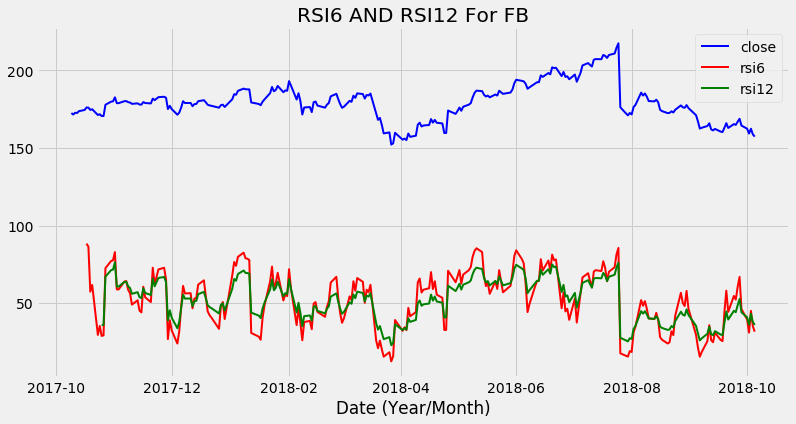

In [7]:
# Set style, empty figure and axes
plt.style.use('fivethirtyeight')
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111)

# Get index values for the X axis for FB DataFrame
x_axis = df.index.get_level_values(0)

# Plot Closing Price and Moving Averages
ax.plot(x_axis, df['close'], color='blue', lw=2)
ax.plot(x_axis, df['rsi6'], color='red', lw=2)
ax.plot(x_axis,df['rsi12'],color ='green', lw=2)

# Set Title & Show the Image
ax.set_title('RSI6 AND RSI12 For FB')
ax.set_xlabel('Date (Year/Month)')
ax.legend()

plt.show()

## Basic Assumption
- transaction rate = 0.1%
- Buy / sell at close
- Cannot short
- Risk free rate is 2.5%
- SD = 0.05


## Underlying Asset
- FB

In [8]:
start_money = 100000
risk_free = 0.025
transaction_rate = 0.001
ticker = 'FB'
SD = 0.05
mmd = []
sharpe = []

In [9]:
# Some utility functions
def MMD(w):
    max_so_far = w[0]
    drawdown_so_far = []
    for i in w:
        max_so_far = max(max_so_far,i)
        drawdown = i / max_so_far - 1 
        drawdown_so_far.append(drawdown)
    max_drawdown = min(drawdown_so_far)
    return max_drawdown

def DD(w):
    max_so_far =w[0]
    for i in w:
        max_so_far = max(max_so_far,i)
        drawdown = i / max_so_far - 1
        current_drawdown = min(0,drawdown)
        return current_drawdown
        
        
        
def get_sharpe_ratio(w):
    total_return = w.iloc[-1] / start_money - 1
    annual_return = w.diff().mean() * 255
    annual_std = w.diff().std() * np.sqrt(255)
    sharpe_ratio = (annual_return - risk_free) / annual_std
    return sharpe_ratio

In [10]:
## define yesterday's rsi12
df["rsi12_1"] = df["rsi12"].shift(1)
## define yesterday's rsi6
df["rsi6_1"] = df["rsi6"].shift(1)

In [11]:
### Strategy A: Enter: RSI<30, Exit: RSI >=70 
cash = [start_money]
stock = [0]
net1 = [start_money]

# create trading signals
signal = []
for idx,row in df.iterrows():
    if row.rsi6_1<row.rsi12_1 and row.rsi6>=row.rsi12:
        signal.append(1)
    elif row.rsi12_1 > row.rsi6_1 and row.rsi12 < row.rsi6:
        signal.append(-1)
    elif row.rsi12 > 70:
        signal.append(-1)
    elif row.rsi12 <= 30:
        signal.append(1)
    else:
        signal.append(0)
df["signal"] = signal

In [12]:
for idx,row in df.iterrows():
    if row.signal == 1:
        if DD(net1)<-0.1:
            cash.append(cash[-1] + stock[-1] * row.close *(1-transaction_rate))
            stock.append(0)
        else:
            shares_to_buy = int(cash[-1] / row.close)
            cost = shares_to_buy * row.close * (1+transaction_rate)
            cash.append(cash[-1] - cost)
            stock.append(stock[-1] + shares_to_buy)       
    elif row.signal == -1:
        cash.append(cash[-1] + stock[-1] * row.close *(1-transaction_rate))
        stock.append(0)
    else:
        if DD(net1)<-0.1:
            cash.append(cash[-1] + stock[-1] * row.close *(1-transaction_rate))
            stock.append(0)
        else:
            cash.append(cash[-1])
            stock.append(stock[-1])
    net1.append(stock[-1] * row.close + cash[-1])
    

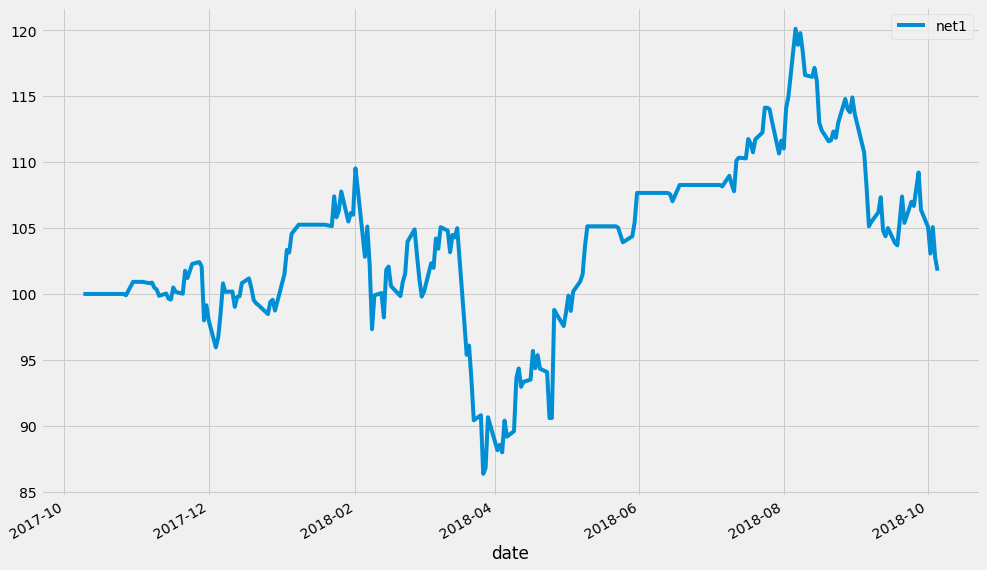

In [13]:
df['net1'] = net1[1:]
df['cash'] = cash[1:]
df['stock'] = stock[1:]
df['net1'] = df['net1'] / start_money * 100
mmd.append(MMD(df['net1'].values))
sharpe.append(get_sharpe_ratio(df['net1']))
df[['date', 'net1']].set_index("date").plot(figsize=(15,10))

In [14]:
data = pd.DataFrame({'Strategy':['Strategy A'],
       'Total Return(%)': [(i / 100 - 1) * 100 for i in [df['net1'].iloc[-1]]],
       'Annual Return(%)': [df[i].pct_change().mean() * 255 * 100 for i in ["net1"]],
       'Max Drawdown(%)':mmd,
       'Sharpe Ratio':sharpe})

In [15]:
data[["Strategy", "Total Return(%)", "Annual Return(%)", "Max Drawdown(%)", "Sharpe Ratio"]]

,Strategy,Total Return(%),Annual Return(%),Max Drawdown(%),Sharpe Ratio
0,Strategy A,1.76913,4.954056,-0.21158,0.069979


In [16]:
len(df)

251

In [17]:
len(cash)

252

In [18]:
len(stock)

252

In [19]:
len(net1)

252